# Model validation
Validation of a fast and differentiable cosmological model. 

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.60' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Model Validation")
from montecosmo.utils import pickle_dump, pickle_load, get_ylim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


2024-02-15 13:51:41.613940: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Render model

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_init_mesh_fn, get_noise_fn
from montecosmo.models import print_config, condition_on_config_mean, default_config as config
# Build and render model
config.update(a_lpt=0.5, mesh_size=256*np.ones(3, dtype=int), box_size=1000*np.ones(3), trace_deterministic=True) # 256 requires 20Gio, 1000
print_config(config)
model = partial(pmrsd_model, **config)
numpyro.render_model(model=model, render_distributions=True, render_params=True)

# CONFIG:
{'mesh_size': array([256, 256, 256]), 'box_size': array([1000., 1000., 1000.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': True, 'prior_config': {'Omega_c': ('\\Omega_c', 0.25, 0.1), 'sigma8': ('\\sigma_8', 0.831, 0.14), 'b1': ('b_1', 1, 0.5), 'b2': ('b_2', 0, 0.5), 'bs': ('b_s', 0, 0.5), 'bnl': ('b_{\\text{nl}}', 0, 0.5)}, 'lik_config': {'obs_std': 1}}

# INFOS:
cell_lengths=[3.90625, 3.90625, 3.90625] Mpc/h
delta_k=0.00628 h/Mpc, k_nyquist=0.80425 h/Mpc
mean_gxy_density=0.060 gxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


## Simulate fiducial

In [3]:
# Get fiducial parameters
fiduc_params = get_simulator(condition_on_config_mean(model, **config))(rng_seed=0)

# Condition model on observables
# obs_names = ['obs_mesh']
obs_names = ['obs_mesh','Omega_c_','sigma8_','b1_','b2_','bs_','bnl_']
obs_params = {name: fiduc_params[name] for name in obs_names}
observed_model = condition(model, obs_params)

# Get and vectorize relevant functionals
score_fn = get_score_fn(observed_model)
multipoles = [0,2,4]
pk_fn = get_pk_fn(multipoles=multipoles, **config)
init_mesh_fn = get_init_mesh_fn(**config)
pk_vfn = jit(vmap(vmap(pk_fn)))
init_mesh_vfn = jit(vmap(vmap(init_mesh_fn)))
fiduc_cosmo = init_mesh_fn(**fiduc_params)[0]
print(f"Fiducial {fiduc_cosmo}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


In [4]:
mlflow.end_run()
mlflow.start_run(run_name="Valid Pk 256")
# mlflow.start_run(run_id="")
mlflow.log_params(config)

## Power spectra

In [5]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace particles. Must compensate for CIC painting convolution
zeros_mesh = jnp.zeros(config['mesh_size'])
pm_mesh = cic_paint(zeros_mesh, fiduc_params['pm_part'])
rsd_mesh = cic_paint(zeros_mesh, fiduc_params['rsd_part'])

# Compute power spectra
pk_init = pk_fn(fiduc_params['init_mesh'])
pk_pm = pk_fn(compensate_cic(pm_mesh))
pk_rsd = pk_fn(compensate_cic(rsd_mesh))
pk_biased = pk_fn(compensate_cic(fiduc_params['biased_mesh']))
pk_lin_init = np.array([pk_init[0], linear_pk_interp(fiduc_cosmo)(pk_init[0])])
pk_lin_obs = np.array([pk_init[0], linear_pk_interp(fiduc_cosmo, a=config['a_obs'])(pk_init[0])])

from montecosmo.metrics import kaiser_formula
from montecosmo.bricks import apply_kaiser_bias

fiduc_kaiser_bias = condition(apply_kaiser_bias, {'b': 1+fiduc_params['b1']})
kaiser_mesh = fiduc_kaiser_bias(fiduc_cosmo, config['a_obs'], fiduc_params['init_mesh'])
pk_kaiser_bias = pk_fn(kaiser_mesh)
pk_kaiser_lin = kaiser_formula(fiduc_cosmo, config['a_obs'], pk_lin_init, 1+fiduc_params['b1'], multipoles)
# pk_kaiser_init = kaiser_formula(fiduc_cosmo, config['a_obs'], pk_init, 1+fiduc_params['b1'], multipoles)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


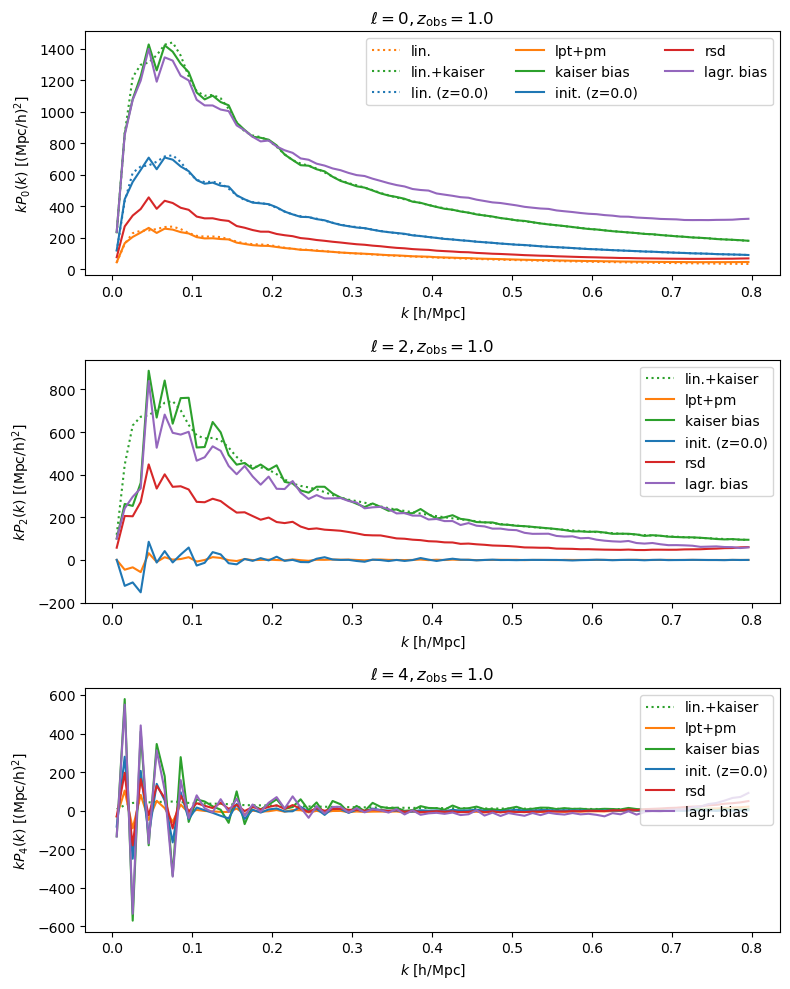

In [6]:
plt.figure(figsize=(8,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_obs, 'C1:', label=f"lin.")
    plot_fn(pk_kaiser_lin, 'C2:', label=f"lin.+kaiser")
    if multipole==0:
        plot_fn(pk_lin_init, 'C0:', label=f"lin. (z={1/1-1:.1f})")

    # plot_fn(pk_kaiser_init, 'C2--', label=f"init.+kaiser")
    plot_fn(pk_pm, 'C1', label=f"lpt+pm")
    plot_fn(pk_kaiser_bias, 'C2', label=f"kaiser bias ")
    plot_fn(pk_init, 'C0', label=f"init. (z={1/1-1:.1f})")
    plot_fn(pk_rsd, 'C3', label=f"rsd")
    plot_fn(pk_biased, 'C4', label=f"lagr. bias")

    if multipole==0: plt.legend(ncols=3, loc='upper right')
    else: plt.legend(loc='upper right')
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_dth0.svg")
plt.show();

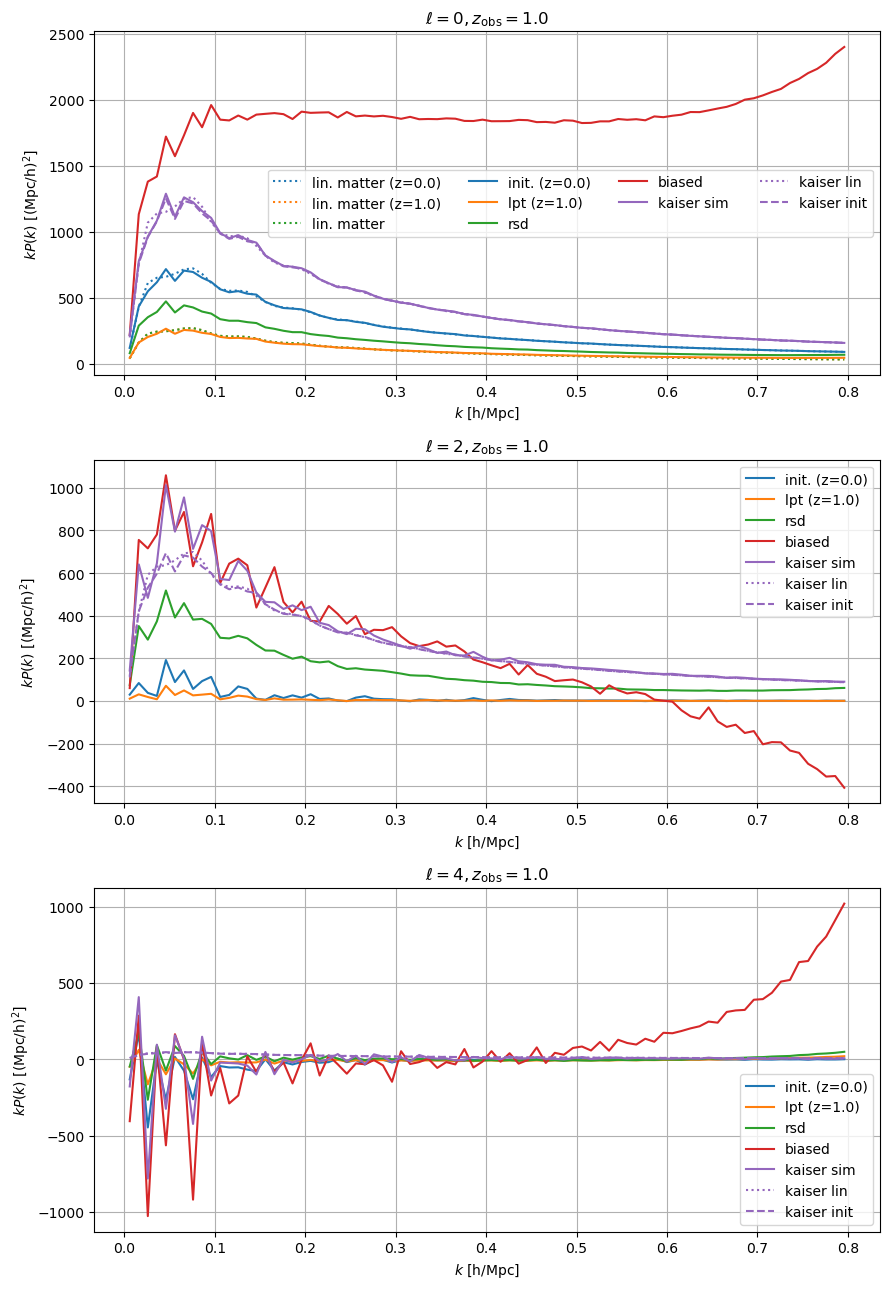

In [ ]:
plt.figure(figsize=(9,13))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole], *args, **kwargs)

    if multipole==0:
        plot_fn(pk_lin_init, 'C0:', label=f"lin. matter (z={1/1-1:.1f})")
        plot_fn(pk_lin_obs, 'C1:', label=f"lin. matter (z={1/config['a_obs']-1:.1f})")

    plot_fn(pk_init, 'C0', label=f"init. (z={1/1-1:.1f})")
    plot_fn(pk_pm, 'C1', label=f"pm")
    plot_fn(pk_rsd, 'C2', label=f"rsd")
    plot_fn(pk_gxy, 'C3', label=f"gxy")

    plot_fn(pk_kaiser_bias, 'C4', label=f"kaiser sim ")
    plot_fn(pk_kaiser_lin, 'C4:', label=f"kaiser lin")
    plot_fn(pk_kaiser_init, 'C4--', label=f"kaiser init")

    if multipole==0: plt.legend(ncols=4)
    else: plt.legend()
    plt.grid(), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title(r"$\ell="+f"{multipole}, "+r"z_{\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
plt.savefig("../scratch/npys/kPk_256_1000Mpcph_linlin")
plt.show();

## Bias effects

In [7]:
b_vals = [-3, 3]
b_names = ['b2','bs','bnl']
b_namlabvals = [['b2=bs=bnl', '$b_2=b_s=b_{\\text{nl}}$', 0]]
for b_nam in b_names:
    for b_val in b_vals:
        b_lab, b_mean, b_std = config['prior_config'][b_nam]
        b_lab = '$'+b_lab+'$'
        b_val = (b_val - b_mean) / b_std
        b_namlabvals.append([b_nam+'_', b_lab, b_val])

pk_biases = []
for b_nam, _, b_val in b_namlabvals:
    cond_params = dict(fiduc_params)
    cond_params[b_nam] = b_val
    params = get_simulator(condition(model, cond_params))(rng_seed=0)
    pk_biases.append(pk_fn(compensate_cic(params['biased_mesh'])))

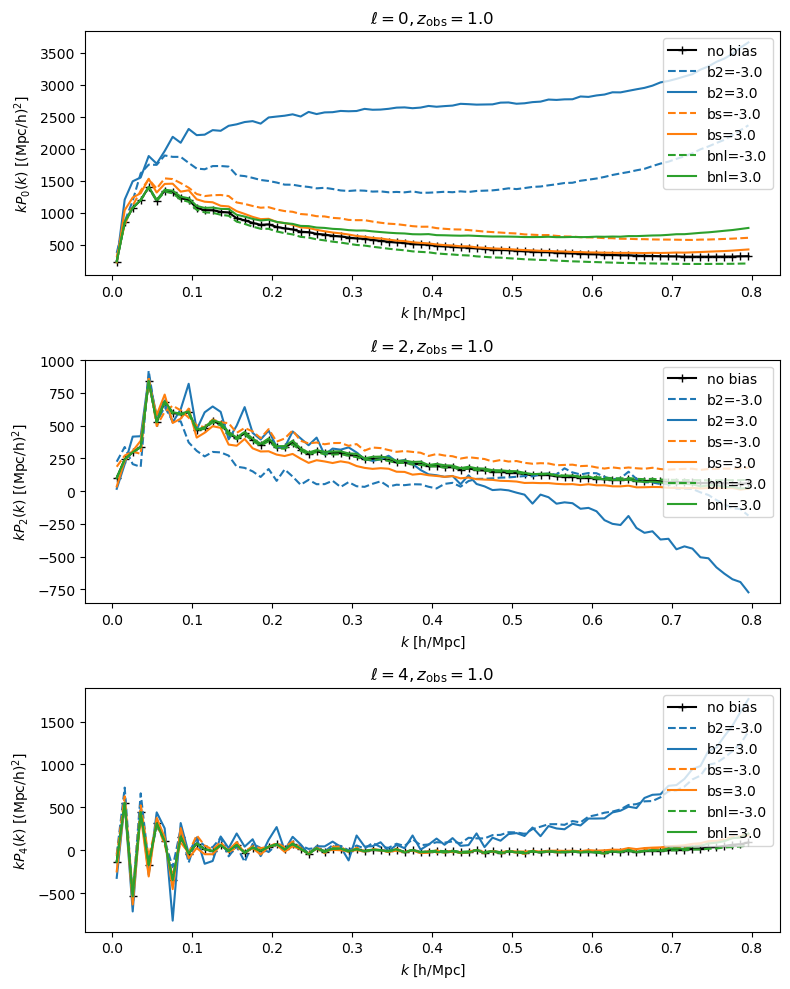

In [8]:
plt.figure(figsize=(8,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)

    colors = ['k+-','C0','C1','C2']
    i_color = 0
    format = colors[i_color]
    for pk, (b_nam, b_lab, b_val), in zip(pk_biases, b_namlabvals):
        if b_val==0:
            label = "no bias"
        else:
            _, b_mean, b_std = config['prior_config'][b_nam[:-1]]
            label = b_nam[:-1]+f"={b_val*b_std+b_mean:.1f}"
            if b_val<0:
                i_color+=1
                format = colors[i_color]+'--'
            else:
                format = colors[i_color]
        plot_fn(pk, format, label=label)

    plt.legend(loc='upper right'), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title("$\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_biases.svg")
plt.show();

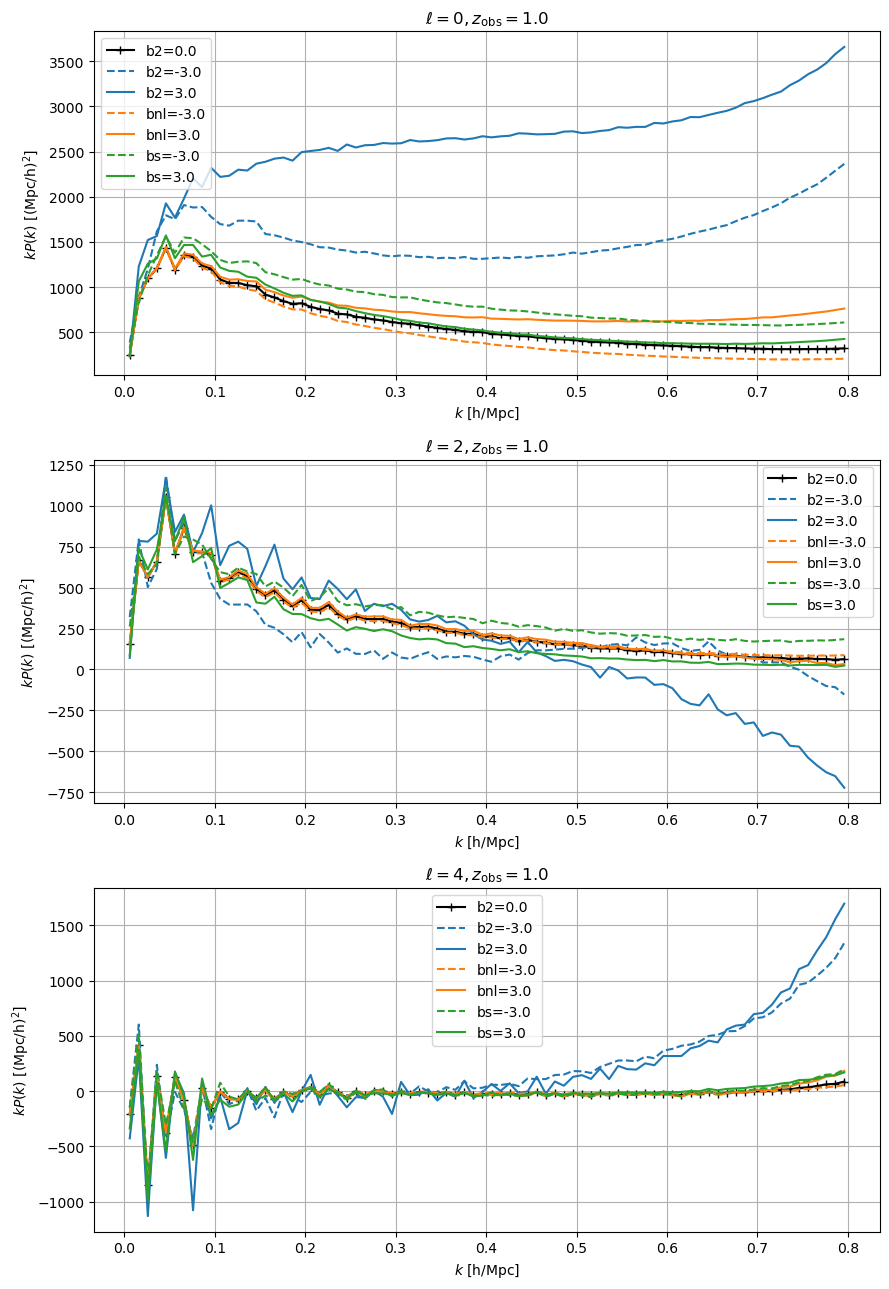

In [ ]:
plt.figure(figsize=(8,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)

    if multipole==0:
        plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1][i_pole], *args, **kwargs)
    else:
        plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1][i_pole], *args, **kwargs)

    colors = ['k+-','C0','C1','C2']
    i_color = 0
    format = colors[i_color]
    for pk, (bias_name, b_label, bias_val), in zip(pk_biases, b_nam_lab_vals):
        label = f"{b_label}={bias_val:.1f}"
        if bias_val<0:
            i_color+=1
            format = colors[i_color]+'--'
        elif bias_val>0:
            format = colors[i_color]
        elif bias_val==0:
            label = '='.join(b_labels)+'=0'
        plot_fn(pk, format, label=label)

    plt.legend(), plt.grid(), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
    plt.title(r"$\ell="+f"{multipole}, "+r"z_{\text{obs}}="+f"{1/config['a_obs']-1:.1f}$")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_biases.svg")
plt.show();

## Validation 

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


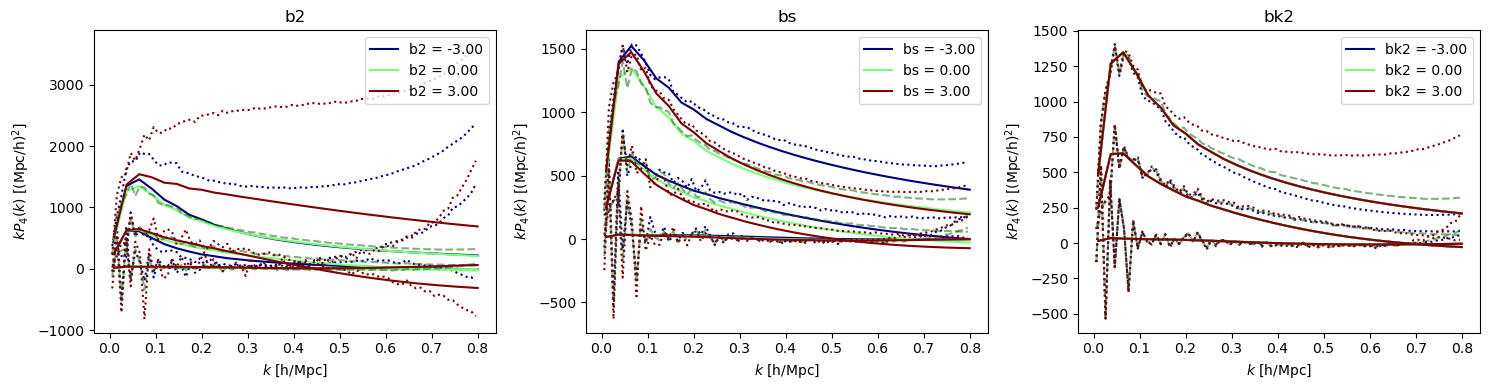

In [13]:
# %pip install git+https://github.com/sfschen/ZeNBu -q
import numpy as np
from matplotlib import pyplot as plt

def get_pt(kv, klin, pklin, f=None):
    """
    Return Zeldovich prediction.

    Parameters
    ----------
    kv : array
        Output k.

    klin : array
        Input linear k.

    pklin : array
        Output P(k).

    f : float
        Growth rate.
    """
    from ZeNBu.zenbu import Zenbu
    from ZeNBu.zenbu_rsd import Zenbu_RSD
    cutoff = np.pi * 512 / 1000.
    if f is None:  # real space
        zobj = Zenbu(klin, pklin, jn=15, N=3000, cutoff=cutoff)
        zobj.make_ptable(kvec=kv)
        tmp = zobj.pktable.T[1:]  # first is k, drop it
        pktable = np.zeros((14,) + tmp.shape[1:], dtype='f8')
        pktable[:10, ...] = tmp[:10, ...]
        pktable[10:, ...] = -kv[np.newaxis, :]**2 * tmp[[0, 1, 3, 6], ...]  # nabla
        pktable = pktable[:, None, :]
    else:
        lpt = Zenbu_RSD(klin, pklin, jn=15, N=2500, cutoff=cutoff)
        lpt.make_pltable(f, kv=kv, nmax=8, ngauss=3)

        p0table = lpt.p0ktable
        p2table = lpt.p2ktable
        p4table = lpt.p4ktable

        pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
        pktable[:, 0, :] = p0table
        pktable[:, 1, :] = p2table
        pktable[:, 2, :] = p4table
        pktable = pktable.T

    return pktable


def get_pk(pktable, b1=1., b2=0., bs=0., bk2=0.):

    """Return galaxy power spectrum prediction."""
    pktable = pktable[:14]
    bias_monomials = np.array([1,
                                2*b1, b1**2,
                                b2, b1*b2, 0.25*b2**2,
                                2*bs, 2*b1*bs, b2*bs, bs**2,
                                2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs])

    # sum for each multipole and combine into pk
    return np.sum(bias_monomials[:, None, None] * pktable, axis=0)


kv = np.linspace(0.01, 0.8, 30)
klin = np.logspace(-3., 2, 1000)

# from cosmoprimo.fiducial import DESI
# cosmo = DESI()
# z = 1.
# f = cosmo.growth_rate(z)
# pklin = cosmo.get_fourier().pk_interpolator()(k=klin, z=z)
from jaxpm.growth import growth_factor, growth_rate
from montecosmo.bricks import linear_pk_interp
f = growth_rate(fiduc_cosmo, jnp.atleast_1d(config['a_obs']))
pklin = linear_pk_interp(fiduc_cosmo, config['a_obs'], n_interp=256)(klin)

plt.figure(figsize=(15,4))
rsd = True
if rsd:  # if RSD, k^2 not modelled?
    ells = (0, 2, 4)
    pktable = get_pt(kv, klin, pklin, f)
else:
    ells = (0,)
    pktable = get_pt(kv, klin, pklin, f=None)

biases = [('b2', np.linspace(-3., 3., 3)), ('bs', np.linspace(-3., 3., 3)), ('bk2', np.linspace(-3., 3., 3))]
for i_param, (param, values) in enumerate(biases):
    plt.subplot(1,len(biases),i_param+1)
    plt.title(f"{param}")
    cmap = plt.get_cmap('jet', len(values))
    for ivalue, value in enumerate(values):
        poles = get_pk(pktable, **{param: value})
        color = cmap(ivalue / len(values))
        for ill, ell in enumerate(ells):
            plt.plot(kv, kv * poles[ill], color=color, label='{} = {:.2f}'.format(param, value) if ill == 0 else None)
            plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[ill+1], *args, **kwargs)
            if value<0:
                plot_fn(pk_biases[1+2*i_param], color=color, linestyle=':')
            elif value>0:
                plot_fn(pk_biases[2+2*i_param], color=color, linestyle=':')
            else:
                plot_fn(pk_biases[0], color='darkgreen', linestyle='--', alpha=0.5)
    plt.legend(loc='upper right'), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_biasvalid.svg")
plt.show()

## Cubes

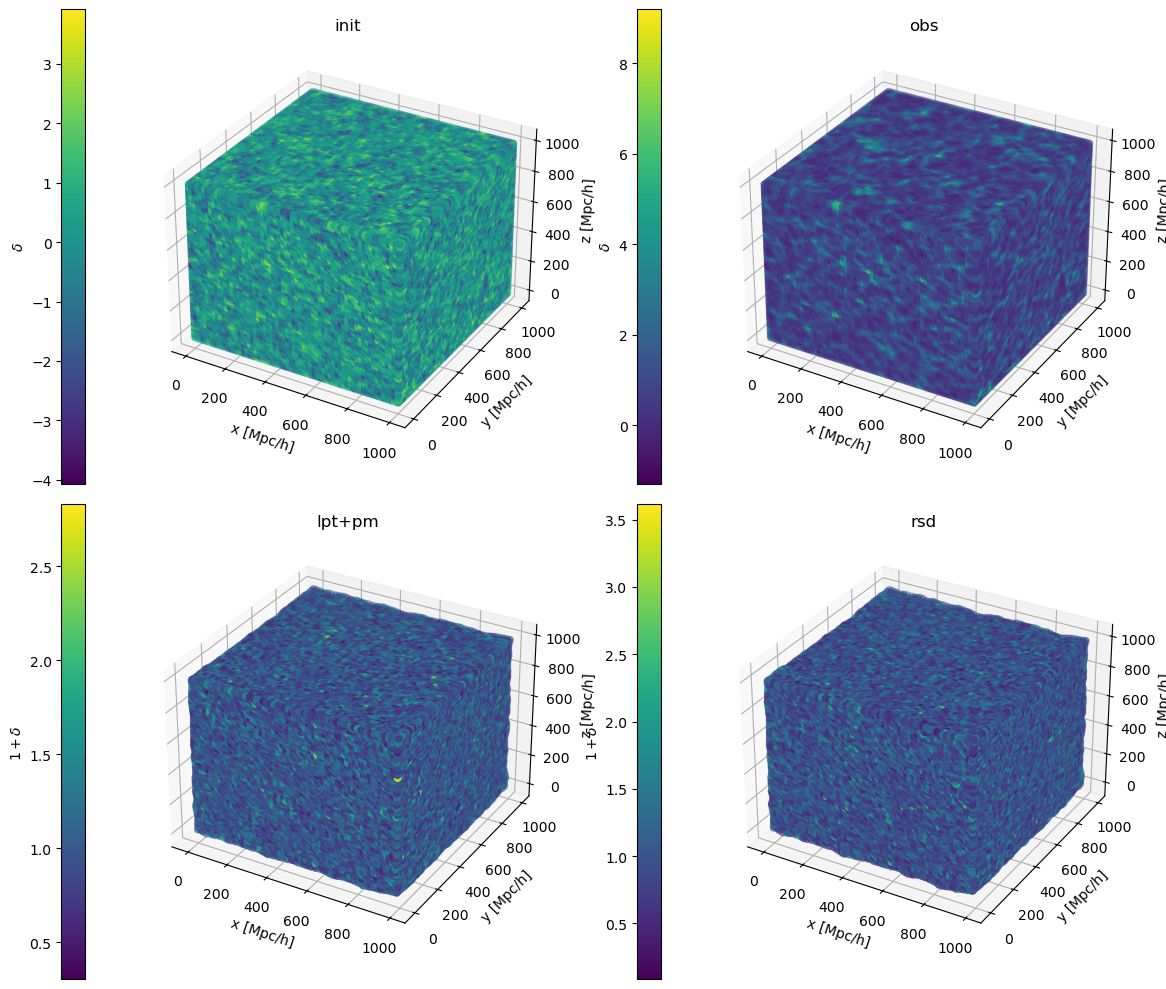

In [10]:
plt.figure(figsize=(lambda h:(2*h*7/6,2*h))(5))
# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_l,mesh_l*1j) 
                for mesh_l,box_l in zip(config['mesh_size'],config['box_size'])]]
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(221, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=fiduc_params['init_mesh'], cmap=cmap)
ax3D.set_xlabel("x [Mpc/h]"), ax3D.set_ylabel("y [Mpc/h]"), ax3D.set_zlabel("z [Mpc/h]")
plt.colorbar(p3d, location='left').set_label("$\delta$"), plt.title("init")

ax3D = plt.subplot(222, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=fiduc_params['biased_mesh'], cmap=cmap)
ax3D.set_xlabel("x [Mpc/h]"), ax3D.set_ylabel("y [Mpc/h]"), ax3D.set_zlabel("z [Mpc/h]")
plt.colorbar(p3d, location='left').set_label("$\delta$"), plt.title("biased")

ax3D = plt.subplot(223, projection='3d')
pos = fiduc_params['pm_part'] * (config['box_size'] / config['mesh_size'])
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(pm_mesh, pos))
ax3D.set_xlabel("x [Mpc/h]"), ax3D.set_ylabel("y [Mpc/h]"), ax3D.set_zlabel("z [Mpc/h]")
plt.colorbar(p3d, location='left').set_label("$1+\delta$"), plt.title("lpt+pm")

ax3D = plt.subplot(224, projection='3d')
pos = fiduc_params['rsd_part'] * (config['box_size'] / config['mesh_size'])
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(rsd_mesh, pos))
ax3D.set_xlabel("x [Mpc/h]"), ax3D.set_ylabel("y [Mpc/h]"), ax3D.set_zlabel("z [Mpc/h]")
plt.colorbar(p3d, location='left').set_label("$1+\delta$"), plt.title("rsd")
# ax3D.set_box_aspect(None, zoom=0.8)
plt.tight_layout(), 

mlflow.log_figure(plt.gcf(), f"cubes.png")
plt.show();